In [1]:
from data_loader import data_loader, preprocess
from model_helper import get_tuned_gamma, train, tune_lambda, plot_lambda_tuning
import numpy as np
from PCA import project_and_plot_PCA, plot_reconstruction_loss, PCA, fair_PCA, corr_plot
import pandas as pd
from Bootstrap_and_eval import eval, bootstrap_eval_one, plot_violin_metrics_with_ci_single
from NN import train_and_evaluate_nn

# Retriving, splitting and preprocessing data

In [2]:
one_hot_cols = ['Race_American_Indian_Alaska_Native',
        'Race_Asian',
        'Race_Black_African_American',
        'Race_Native_Hawaiian_Pacific_Islander',
        'Race_White',
        #'Race_Info_Not_Provided',
        #'Race_Not_applicable',
        #'Race_No_co_applicant', 
        'Race_White_Latino']
one_hot = True
df = data_loader(one_hot_cols, num=1000)

# filter columns to only include columns in the features list below
features = ['loan_amount_000s', 'loan_type', 'owner_occupancy', 
       'property_type','applicant_income_000s', 'purchaser_type', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units', 
       'number_of_1_to_4_family_units', 'race_ethnicity', 'state_code', 'county_code',
       'joint_sex', "minority_population", 'lien_status']
if one_hot:
       #features = features + one_hot_cols
       # remove  'race_ethnicity' from features
       features.remove('race_ethnicity')
x_train, x_test, y_train, y_test, train_groups, test_groups = preprocess(df, features, one_hot_cols)
print(f'All rows in train_groups sum to 1: {np.allclose(np.sum(train_groups, axis=1), 1)}')

Loading data...
processed_data.csv exists. Loading data from file.
Num features BEFORE filtering features 54
Num features AFTER filtering features 15
x_train shape:  (445, 15)
y_train shape:  (112, 15)
All rows in train_groups sum to 1: True


# Varitions of Logistic Reggression(LR) models 

### Vanilla LR 

In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = 'NO l2'

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_, best_gamma, lambda_val=1)  # do use l2 regularization here ergo False


### Find optimal regulazation strength of L2

In [ ]:
betas = np.random.rand(x_train.shape[1])
gammas = np.linspace(0.1, 1, 10)
best_gamma = get_tuned_gamma(gammas, x_train, y_train, num_folds=5, verbose=False)


### Train LR With L2

In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = False

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, best_gamma, fair_loss_) 

### Find regulazation strength of fair loss(lambda)
Then train L2 + Fairness loss

In [ ]:
fair_loss_ = True
best_gamma = 0.1
performance_metrics = tune_lambda(x_train, y_train, test_groups, train_groups, x_test, y_test, fair_loss_, best_gamma, one_hot_cols=one_hot_cols)

In [ ]:
lambda_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 1]
plot_lambda_tuning(performance_metrics, lambda_vals, one_hot_cols=one_hot_cols)


In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = True

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_, best_gamma) 

In [ ]:
# print shape of x_train, y_train, x_test, y_test, groups,
print("x_train shape: ", x_train.shape, type(x_train))
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape, type(x_test))
print("y_test shape: ", y_test.shape, type(y_test))
print("train groups shape: ", train_groups.shape)
print("test groups shape: ", test_groups.shape)


# Fair PCA 

Fit PCA components to data

In [ ]:
x_train_pd = pd.DataFrame(x_train, columns=features)
x_test_pd = pd.DataFrame(x_test, columns=features)
project_and_plot_PCA(x_train_pd, n_components=len(features), size = (25,10),corr_metric='pearson')

In [ ]:
corr_plot(x_train_pd, 'pearson', train_groups, n_components=len(features), fair=False)
corr_plot(x_train_pd, 'pearson', train_groups, n_components=len(features), fair=True)

In [ ]:
plot_reconstruction_loss(x_train_pd, x_test_pd, len(features), train_groups, fair=False)

Train model on fair PCA data 

In [ ]:
normal_preds, pca_preds, fair_preds = eval(x_train_pd, x_test_pd, y_test, y_train, y_test, train_groups)

In [ ]:
best_gamma = 0.1
unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_=False, best_gamma=best_gamma)  # do use l2 regularization here ergo False
n_bootstrap = 1000
sample_size = 500
accuracy_scores, f1_scores, precision_scores, recall_scores = bootstrap_eval_one(unfair_preds, None, y_test, n_bootstrap, sample_size)
plot_violin_metrics_with_ci_single(accuracy_scores, f1_scores, precision_scores, recall_scores, confidence_level=0.95)


# BLACK BOX MODEL

Epoch 1/100, Loss: 0.676562522138868
Epoch 2/100, Loss: 0.5422509397779193
Epoch 3/100, Loss: 0.4838653824159077
Epoch 4/100, Loss: 0.4440968355962208
Epoch 5/100, Loss: 0.41580743874822346
Epoch 6/100, Loss: 0.39334985613822937
Epoch 7/100, Loss: 0.37577645906380247
Epoch 8/100, Loss: 0.3617322114961488
Epoch 9/100, Loss: 0.34913300616400583
Epoch 10/100, Loss: 0.339239307812282
Epoch 11/100, Loss: 0.32965280222041266
Epoch 12/100, Loss: 0.31888373834746225
Epoch 13/100, Loss: 0.3106550137911524
Epoch 14/100, Loss: 0.30150061420031954
Epoch 15/100, Loss: 0.294631082032408
Epoch 16/100, Loss: 0.2882713239107813
Epoch 17/100, Loss: 0.28266587214810507
Epoch 18/100, Loss: 0.27385901446853367
Epoch 19/100, Loss: 0.2679594840322222
Epoch 20/100, Loss: 0.26229044049978256
Epoch 21/100, Loss: 0.25435622142893927
Epoch 22/100, Loss: 0.25074074204478947
Epoch 23/100, Loss: 0.2442831343838147
Epoch 24/100, Loss: 0.2387949451804161
Epoch 25/100, Loss: 0.23500719772917883
Epoch 26/100, Loss: 0.22

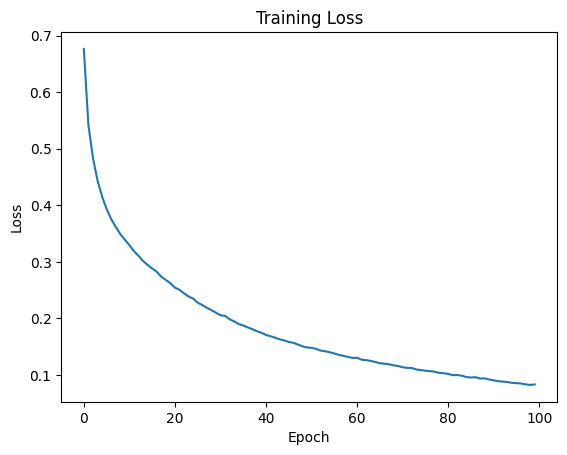

Test Accuracy: 78.57142857142857%


(SimpleNN(
   (fc1): Linear(in_features=15, out_features=128, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=128, out_features=2, bias=True)
 ),
 78.57142857142857)

In [11]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

train_and_evaluate_nn(x_train_np, x_test_np, y_train_np, y_test_np,num_epochs=100, plot_loss=True)


### NN trained on fair PCA data

Epoch 1/100, Loss: 0.6233174587999072
Epoch 2/100, Loss: 0.5203835432018552
Epoch 3/100, Loss: 0.4790416955947876
Epoch 4/100, Loss: 0.4548524043389729
Epoch 5/100, Loss: 0.43777076474257876
Epoch 6/100, Loss: 0.424763736980302
Epoch 7/100, Loss: 0.4164000643151147
Epoch 8/100, Loss: 0.40966547812734333
Epoch 9/100, Loss: 0.4040245573435511
Epoch 10/100, Loss: 0.39930073810475214
Epoch 11/100, Loss: 0.39374966280800955
Epoch 12/100, Loss: 0.38965463425431934
Epoch 13/100, Loss: 0.3869765081575939
Epoch 14/100, Loss: 0.38457380660942625
Epoch 15/100, Loss: 0.3805109943662371
Epoch 16/100, Loss: 0.37853087059089113
Epoch 17/100, Loss: 0.37454222036259516
Epoch 18/100, Loss: 0.3711144583565848
Epoch 19/100, Loss: 0.3687348791531154
Epoch 20/100, Loss: 0.3663471681731088
Epoch 21/100, Loss: 0.36276431168828693
Epoch 22/100, Loss: 0.36020685732364655
Epoch 23/100, Loss: 0.35631575754710604
Epoch 24/100, Loss: 0.3550709741456168
Epoch 25/100, Loss: 0.3526194127542632
Epoch 26/100, Loss: 0.35

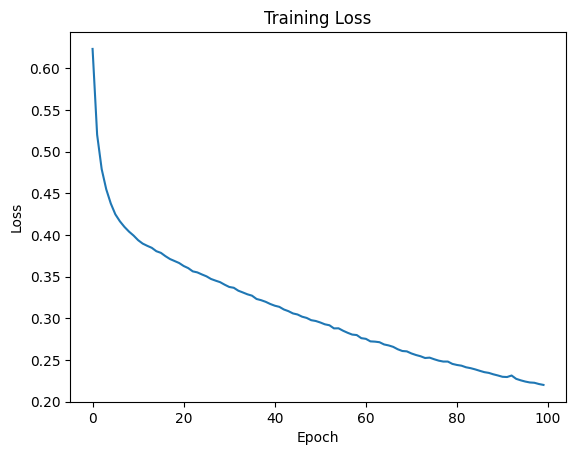

Test Accuracy: 82.14285714285714%


(SimpleNN(
   (fc1): Linear(in_features=10, out_features=128, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=128, out_features=2, bias=True)
 ),
 82.14285714285714)

In [12]:
x_train_fair, U, explained_variance = fair_PCA(x_train, 15, train_groups)
x_test_fair = x_test_np @ U
train_and_evaluate_nn(x_train_fair, x_test_fair, y_train_np, y_test_np,num_epochs=100, plot_loss=True)
